<a href="https://colab.research.google.com/github/wertyyyy12/376_Measurements/blob/main/376_Measurement_Plots.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt
import pandas as pd

Fourier analysis statistics for data at ./f4tek0008CH2.csv:
T_fft = 9.99999
Navgs = 49.99995 with nperseg = 20000
calculated frequency resolution = 5.0
Fourier analysis statistics for data at ./n5tek0008CH2.csv:
T_fft = 9.99999
Navgs = 49.99995 with nperseg = 20000
calculated frequency resolution = 5.0


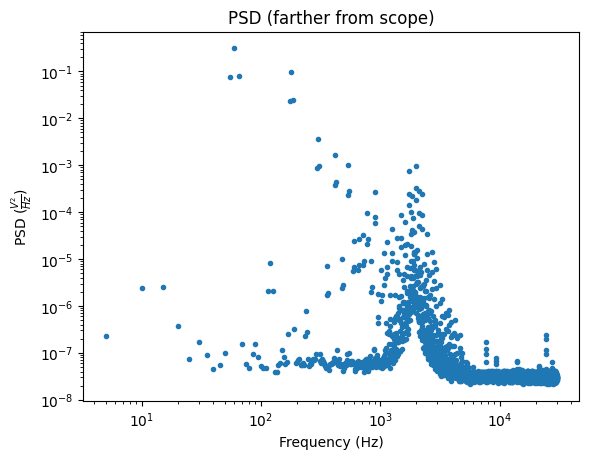

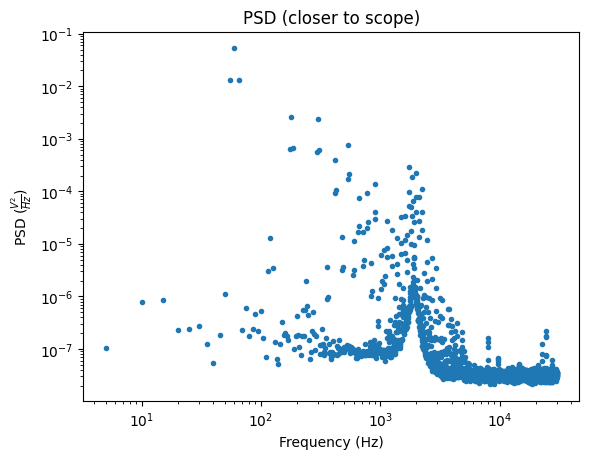

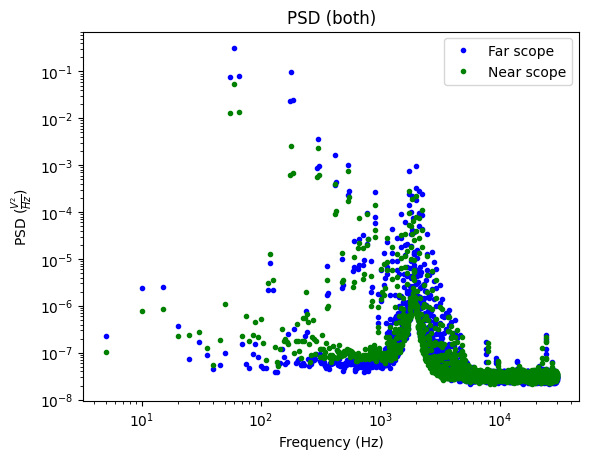

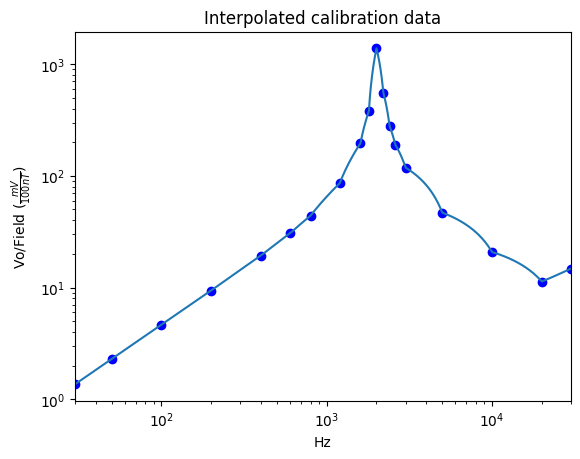

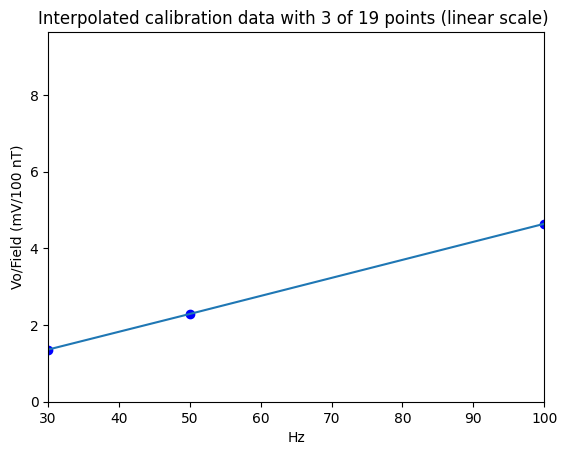

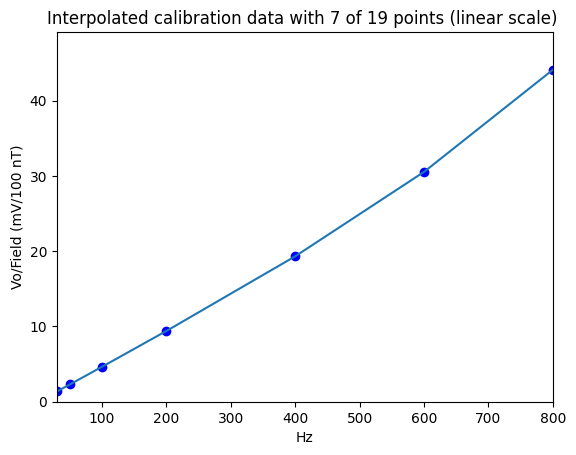

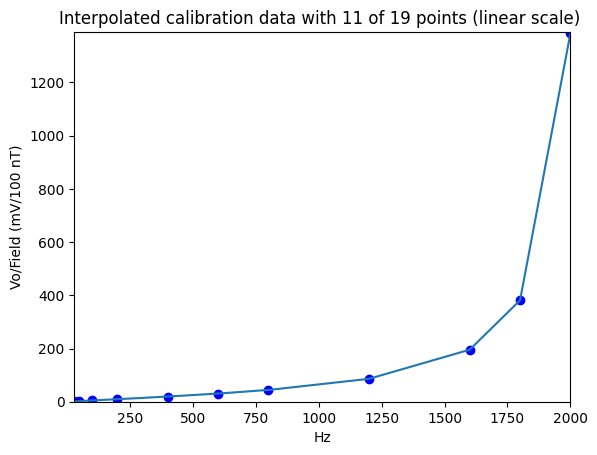

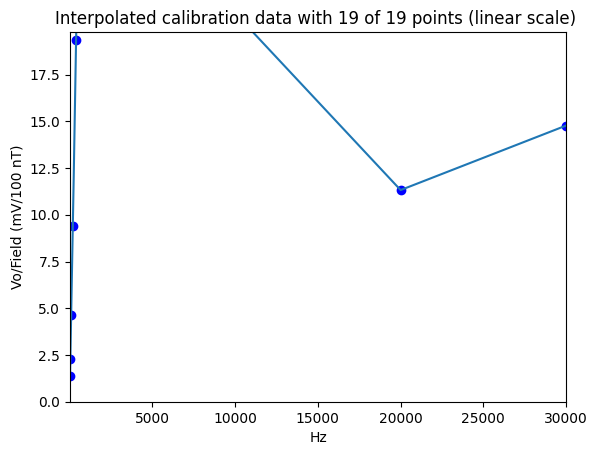

actual frequency resolution is 5.0. The frequencies array is [0.0000e+00 5.0000e+00 1.0000e+01 ... 2.9990e+04 2.9995e+04 3.0000e+04]
actual frequency resolution is 5.0. The frequencies array is [0.0000e+00 5.0000e+00 1.0000e+01 ... 2.9990e+04 2.9995e+04 3.0000e+04]
actual frequency resolution is 5.0. The frequencies array is [0.0000e+00 5.0000e+00 1.0000e+01 ... 2.9990e+04 2.9995e+04 3.0000e+04]
actual frequency resolution is 5.0. The frequencies array is [0.0000e+00 5.0000e+00 1.0000e+01 ... 2.9990e+04 2.9995e+04 3.0000e+04]


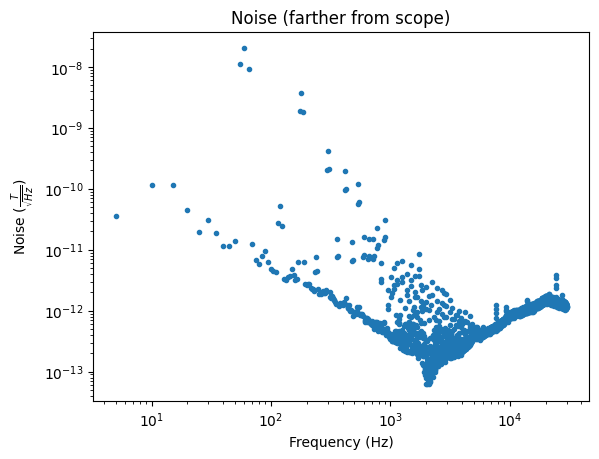

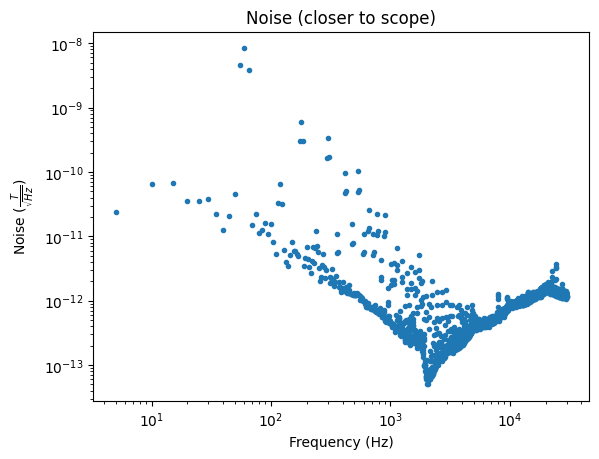

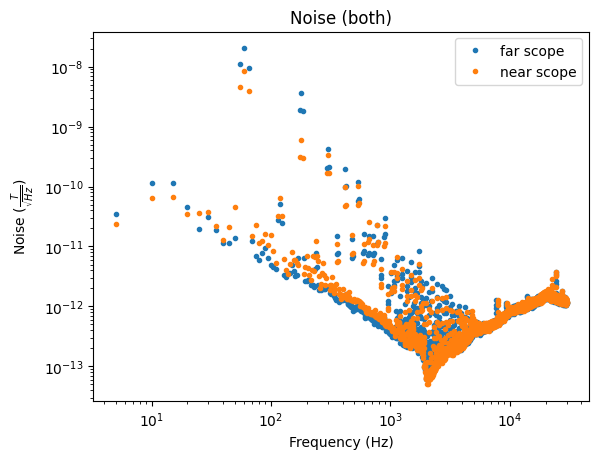

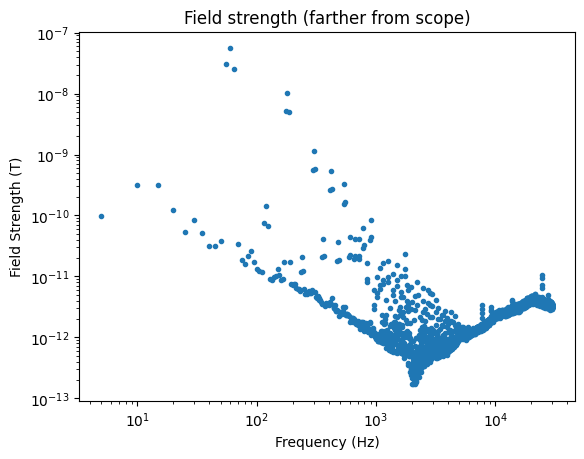

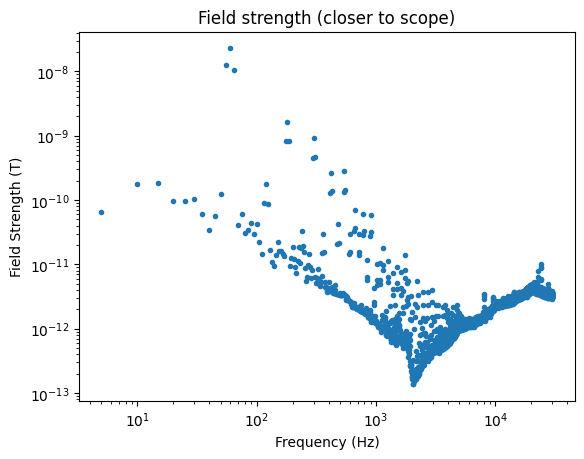

In [ ]:
NEAR_DATA = "./n5tek0008CH2.csv"
FAR_DATA = "./f4tek0008CH2.csv"
SAMPLE_INTERVAL = 1e-05 # you can verify this number by looking at the CSV files. find "Sample Interval".
GLOBAL_HZ_LIMIT = 30e3 # the value, in kHz, after which calibration data drops abruptly. linear interpolation doesn't work after this Hz value.

# read calibration data
df = pd.read_csv('./calibration_data.csv', names=['Frequency', 'Vo/Field'])
df = df.query("Frequency <= 30")
calibration_frequency_pts = df['Frequency'].values * 1e3 # in Hz
calibration_constant_pts = df['Vo/Field'].values

NPERSEG = 20000 # we use this value for both plots

# prints N_avgs and calculated frequency resolution from a set of times, the sample interval of those times, and nperseg.
# Note the "actual" frequency resolution comes from the spacing of frequencies
# from the output of the welch function, but the actual and calculated resolutions should be virtually identical.
def printFourierAnalysisStats(times, nperseg, sample_interval, data_path):
	print(f"Fourier analysis statistics for data at {data_path}:")
	T_fft = times[-2] - times[0] # the last time entry isn't a number for some reason
	N_avgs = (T_fft / sample_interval) / nperseg

	print(f"T_fft = {T_fft}")
	print(f"Navgs = {N_avgs} with nperseg = {nperseg}")
	print(f"calculated frequency resolution = {N_avgs / T_fft}")

# apply the welch function to some data in data_path.
# `units` toggles the scaling for welch(). V^2/Hz is the noise scaling
# `print_stats` prints fourier analysis stats with the above function. can turn off by passing False
def apply_welch(data_path, nperseg, units, print_stats=True):
	assert units=="V^2/Hz" or units=="V^2", "units must be one of: V^2/Hz, V^2"
	df = pd.read_csv(data_path, skiprows=14, names=['Time', 'Amplitude'])

	times = df['Time'].values
	amplitude = df['Amplitude'].values
	if print_stats:
		printFourierAnalysisStats(times, nperseg, SAMPLE_INTERVAL, data_path)

	# compute psd
	frequencies, psd = welch(amplitude, 1 / SAMPLE_INTERVAL, nperseg=nperseg, \
						  	scaling=("density" if units == "V^2/Hz" else "spectrum"))

	# filter out frequencies bigger than 30 kHz
	mask = frequencies <= GLOBAL_HZ_LIMIT
	frequencies = frequencies[mask]
	psd = psd[mask]
	return frequencies, psd

# helper plot function that saves a lot of repetition.
# This function can plot multiple functions on the same graph with different format strings
# `X` and `Y`` are python lists of various x and y values to plot on the same plot. Each element of X and Y should have the ArrayLike type (eg np.ndarray)
# `qty_labels` are legend labels
# `fmts` is an array of format strings to be passed into each plot.
# you can think of each element of X and Y as a seperate thing to plot. this thing gets an fmt string given by the order of X and Y.
# if this is a little unclear, look at the usages below and also the for loop of this function.
def plot(title, X, Y, x_axis_label, y_axis_label, qty_labels=None, scale="linear", xlim=None, ylim=None, fmts=[]):
	plt.figure()
	ax = plt.subplot()
	assert type(X) == list, "X must be a list of xvals to plot"
	assert type(Y) == list, "Y must be a list of yvals to plot"
	assert type(fmts) == list, "markers must be a list of format strings, one for each plot"
	assert len(X) == len(Y), "X, Y, and fmts must have same length"
	assert len(fmts) <= len(X), f"cannot have more format strings than plots; {len(fmts)} formats but {len(X)} plots"
	assert (qty_labels is None) or (len(qty_labels) == len(X)), "if qty_labels is specified, its length must match that of X and Y"
	ax.set_title(title)
	ax.set_xlabel(x_axis_label)
	ax.set_ylabel(y_axis_label)
	if xlim is not None:
		ax.set_xlim(xlim)
	if ylim is not None:
		ax.set_ylim(ylim)
	# if ax.get_xlim()[1] > GLOBAL_HZ_LIMIT:
	args = {}
	if len(fmts) < len(X):
		for _ in range(len(X) - len(fmts)):
			fmts.append("") # equivalent to default
	for idx, _ in enumerate(X):
		if qty_labels is not None:
			args.update({"label": qty_labels[idx]})
		if scale == "linear":
			ax.plot(X[idx], Y[idx], fmts[idx], **args)
		elif scale == "loglog":
			ax.loglog(X[idx], Y[idx], fmts[idx], **args)
	if qty_labels is not None:
		ax.legend()

# plot the interpolation of the calibration data.
# using debug=True shows the interpolation in linear scale in several plots,
# making it very clear that in fact the interpolation is linear.
def plot_interp(psd_frequencies, calibration_interp, debug=False):
	plot("Interpolated calibration data", [calibration_frequency_pts, psd_frequencies], [calibration_constant_pts, calibration_interp(psd_frequencies)], \
	  "Hz", "Vo/Field $(\\frac{mV}{100 nT})$", scale="loglog", xlim=[calibration_frequency_pts[0], calibration_frequency_pts[-1]], fmts=["bo"])
	if debug:
		for (i, index_to_graph) in enumerate([2, 6, 10, len(calibration_constant_pts) - 1]):
			plot(\
				f"Interpolated calibration data with {index_to_graph + 1} of {len(calibration_constant_pts)} points (linear scale) ", \
				[calibration_frequency_pts, psd_frequencies], \
				[calibration_constant_pts, calibration_interp(psd_frequencies)], \
				"Hz", "Vo/Field (mV/100 nT)", \
				xlim=[calibration_frequency_pts[0], calibration_frequency_pts[index_to_graph]], \
				ylim=[0, calibration_constant_pts[index_to_graph] + 5], fmts=["bo"] \
			)
	plt.show()


def apply_calibration_constant(frequencies, welch, show_interp=False): # apply calibration constant on given PSD or amplitude plot generated by welch()
	# Interpolate calibration data
	# The following interp1d call is labeled as legacy so I've just done the numpy equivalent
	# calibration_interp = interp1d(calibration_frequency_pts, calibration_constant_pts, kind='linear', fill_value='extrapolate')
	calibration_interp = lambda x: np.interp(x, calibration_frequency_pts, calibration_constant_pts)
	if show_interp:
		plot_interp(frequencies, calibration_interp, debug=True)
	print(f"actual frequency resolution is {frequencies[1] - frequencies[0]}. The frequencies array is {frequencies}")
	# Compute the square root of the PSD
	sqrt_psd = np.sqrt(welch)
	# Multiply by the interpolated calibration function
	adjusted_psd = (sqrt_psd / calibration_interp(frequencies)) * 1e-7
	return frequencies, adjusted_psd

far_freq, far_psd = apply_welch(FAR_DATA, NPERSEG, "V^2/Hz")
near_freq, near_psd = apply_welch(NEAR_DATA, NPERSEG, "V^2/Hz")
plot("PSD (farther from scope)", [far_freq], [far_psd], "Frequency (Hz)", "PSD ($\\frac{V^2}{Hz}$)", scale="loglog", fmts=["."])
plot("PSD (closer to scope)", [near_freq], [near_psd], "Frequency (Hz)", "PSD ($\\frac{V^2}{Hz}$)", scale="loglog", fmts=["."])
plot("PSD (both)", [far_freq, near_freq], [far_psd, near_psd], "Frequency (Hz)", "PSD ($\\frac{V^2}{Hz}$)", scale="loglog", fmts=[".b", ".g"], qty_labels=["Far scope", "Near scope"])
far_freq, far_noise = apply_calibration_constant(far_freq, far_psd, show_interp=True)
near_freq, near_noise = apply_calibration_constant(near_freq, near_psd)
plot("Noise (farther from scope)", [far_freq], [far_noise], "Frequency (Hz)", "Noise ($\\frac{T}{\\sqrt{Hz}}$)", scale="loglog", fmts=["."])
plot("Noise (closer to scope)", [near_freq], [near_noise], "Frequency (Hz)", "Noise ($\\frac{T}{\\sqrt{Hz}}$)", scale="loglog", fmts=["."])
plot("Noise (both)", [far_freq, near_freq], [far_noise, near_noise], "Frequency (Hz)",  "Noise ($\\frac{T}{\\sqrt{Hz}}$)", scale="loglog", fmts=[".", "."], qty_labels=["far scope", "near scope"])

far_freq, far_power = apply_welch(FAR_DATA, NPERSEG, "V^2", print_stats=False)
near_freq, near_power = apply_welch(NEAR_DATA, NPERSEG, "V^2", print_stats=False)
far_freq, far_field = apply_calibration_constant(far_freq, far_power)
near_freq, near_field = apply_calibration_constant(near_freq, near_power)
plot("Field strength (farther from scope)", [far_freq], [far_field], "Frequency (Hz)", "Field Strength (T)", scale="loglog", fmts=["."])
plot("Field strength (closer to scope)", [near_freq], [near_field], "Frequency (Hz)", "Field Strength (T)", scale="loglog", fmts=["."])


